# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Белозёров".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
def sigmoid (val):
    return 1.0/(np.exp (-val) + 1)

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        
    def grad (self, x, y):#here x is only one element and y is just +-1
        return x * (sigmoid (-x.dot(self.beta)) -  y)
    
    def error_print (self, x, y):
        err = 0
        for i in range (x.shape[0]):
            err -= np.log (sigmoid (-x[i].dot(self.beta))) * y[i] + (1 - np.log (sigmoid (-x[i].dot(self.beta)))) *(1 - y[i])
#         print "error:",err
        return err
    
    def fit(self, X, y=None, partial_fit=False):
        '''
        Обучение модели
        '''
        self.errors = []
        x = np.concatenate ((X, np.ones((X.shape[0],1))), axis=1)#and we use x instead of X
        if not partial_fit:
            self.beta = np.ones(x.shape[1])#initialisation of beta array may be improved
        for epoch in range(1,self.max_epoch):  
            shuffled = random.sample (range(x.shape[0]), x.shape[0])
            for iteration, i in enumerate (shuffled):
                self.beta = self.beta + self.alpha / epoch * self.grad (x[i], y[i])
                for b in range(self.beta.shape[0]):#L1 regularisation with clipping http://www.aclweb.org/anthology/P09-1054
                    if self.beta[b] > 0:
                        self.beta[b] -= 1.0 / self.C * self.alpha / epoch
                    else:
                        if self.beta[b] < 0:
                            self.beta[b] += 1.0 / self.C * self.alpha / epoch
#             to draw plot for every epoch
#             plt.plot ([-4,8], [(4 * self.beta[0] - self.beta[2]) / self.beta[1], (-8* self.beta[0] - self.beta[2]) / self.beta[1]])
            self.errors.append (self.error_print (x, y))
            
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.fit (X,y,partial_fit=True)#just do not recreate beta array  
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = []
        x = np.concatenate ((X, np.ones((X.shape[0],1))), axis=1)#and we use x instead of X
        for i in range (x.shape[0]):
            if sigmoid (-x[i].dot(self.beta)) > 0.5:
                y_hat.append (1)
            else:
                y_hat.append (0)
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = []
        x = np.concatenate ((X, np.ones((X.shape[0],1))), axis=1)#and we use x instead of X
        for i in range (x.shape[0]):
            y_hat_proba.append ( sigmoid (-x[i].dot(self.beta)) > 0.5)
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

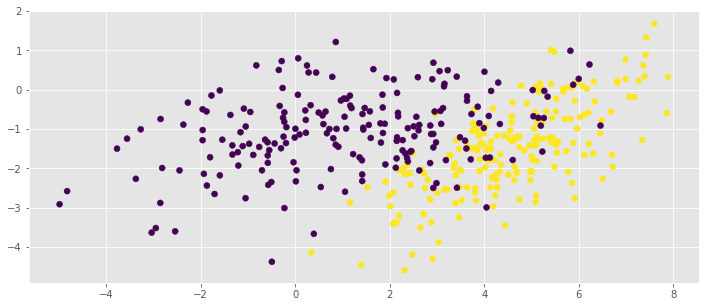

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

weights(the last coefitient is for constant): [-1.24372527  1.39245189  5.85699187]


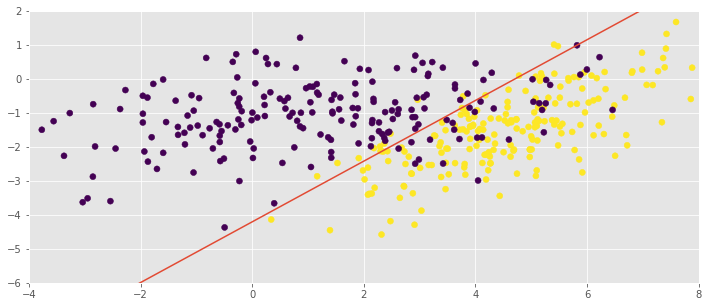

In [5]:
model = MySGDClassifier(alpha=0.2, max_epoch=40, C=200)
model.fit(X, y)
print "weights(the last coefitient is for constant):",model.beta
plt.plot ([-4,8], [(4 * model.beta[0] - model.beta[2]) / model.beta[1], (-8* model.beta[0] - model.beta[2]) / model.beta[1]])
plt.scatter(X[:,0], X[:,1], c=y)
axes = plt.gca()
axes.set_xlim([-4,8])
axes.set_ylim([-6,2])
plt.show ()

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

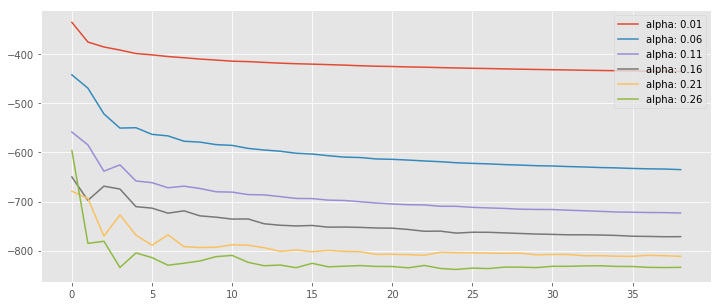

In [6]:
for alpha in np.arange (0.01, 0.3, 0.05):
    model = MySGDClassifier(alpha=alpha, max_epoch=40, C=200)
    model.fit(X, y)
    plt.plot (model.errors, label='alpha: ' + str(alpha))
plt.legend ()